# 使用CNN实现手写数字集识别

In [11]:
import torch
import torchvision
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict
import matplotlib.pyplot as plt

In [12]:
# 参数设置
# 设置随机种子，以确保结果的可重复性
torch.manual_seed(0)
# 定义训练的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 设置batch_size
batch_size = 64
# 设置学习率
learning_rate = 0.001
# 设置动量
momentum = 0.5
# 设置训练的轮数
EPOCH = 10

In [13]:
# 定义数据预处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), # 将图像转化为张量
                               torchvision.transforms.Normalize(0.1307, 0.3081)]) # 标准化图像

# 加载MNIST数据集
train_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=False, transform=transform, download=True)

# 查看数据集大小
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)
print("训练数据集长度为：{}".format(train_dataset_size))
print("测试数据集长度为：{}".format(val_dataset_size))

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

训练数据集长度为：60000
测试数据集长度为：10000


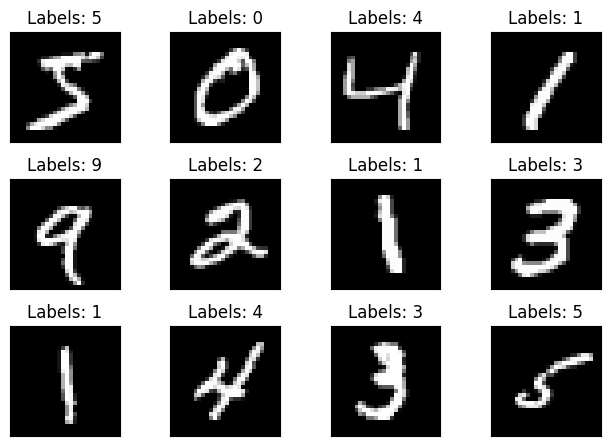

In [14]:
# 展示数据集中部分图片
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

卷积神经网络模型
![](../images/MNIST_cnn_net.png)

In [15]:
# 定义卷积神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 10, kernel_size=5)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv2', nn.Conv2d(10, 20, kernel_size=5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('flatten', nn.Flatten()),
            ('fc1', nn.Linear(320, 50)),  # 320 = 20 * 4 * 4
            ('fc2', nn.Linear(50, 10))
        ]))


    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
# 实例化模型
model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) # 随机梯度下降优化器

writer = SummaryWriter("./logs/MNIST_cnn") # TensorBoard可视化

In [18]:
total_train_step = 0
total_test_step = 0
acc_val = []

# 训练模型
for epoch in range(EPOCH):
    print("--------------------第{}轮训练开始--------------------".format(epoch + 1))
    model.train()

    for data in train_loader:
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_step += 1
        if total_train_step % 100 == 0:
            print ("训练次数：{}，Loss：{}".format(total_train_step, loss.item()))
            writer.add_scalar("train_loss", loss.item(), total_train_step)

    model.eval()
    total_test_loss = 0
    total_correct = 0
    with torch.no_grad():
        for data in val_loader:
            imgs, labels = data
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
        print("测试集上Loss：{}".format(total_test_loss))
        writer.add_scalar("test_loss", total_test_loss, total_test_step)
        print("测试集上正确率：{}%".format(total_correct / val_dataset_size * 100))
        writer.add_scalar("test_acc", total_correct / val_dataset_size * 100, epoch)
        acc_val.append(total_correct / val_dataset_size * 100)
        total_test_step += 1

    torch.save(model.state_dict(), "./models/MNIST_cnn_epoch_{}.pth".format(epoch + 1))
    print("模型已保存！")

    plt.plot(acc_val)
    plt.show()

--------------------第1轮训练开始--------------------
训练次数：100，Loss：0.2144635170698166
训练次数：200，Loss：0.05941637605428696
训练次数：300，Loss：0.14494112133979797
训练次数：400，Loss：0.08950438350439072
训练次数：500，Loss：0.23410190641880035
训练次数：600，Loss：0.10029402375221252
训练次数：700，Loss：0.06358450651168823
训练次数：800，Loss：0.03938022628426552
训练次数：900，Loss：0.08312353491783142
测试集上Loss：11.707932629971765
测试集上正确率：97.81%
模型已保存！
--------------------第2轮训练开始--------------------
训练次数：1000，Loss：0.008352168835699558
训练次数：1100，Loss：0.05719473958015442
训练次数：1200，Loss：0.01944536715745926
训练次数：1300，Loss：0.026192251592874527
训练次数：1400，Loss：0.09809034317731857
训练次数：1500，Loss：0.0535573810338974
训练次数：1600，Loss：0.11682883650064468
训练次数：1700，Loss：0.04717807099223137
训练次数：1800，Loss：0.24579204618930817
测试集上Loss：9.048812259745318
测试集上正确率：98.19%
模型已保存！
--------------------第3轮训练开始--------------------
训练次数：1900，Loss：0.13294856250286102
训练次数：2000，Loss：0.08423185348510742
训练次数：2100，Loss：0.11691881716251373
训练次数：2200，Loss：0.05709278956055

In [ ]:
writer.close()